In [3]:
  # !pip install langchainhub langchain langchain-openai beautifulsoup4 faiss-cpu
  # !pip install langchain-chroma
  # !pip install langchain-community
  # !pip install jq

##test change

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# List all files and directories in your Google Drive
# notebook_folder = '/content/drive/Shareddrives/coupa hackathon (Aug 2024)/'
import os
notebook_folder = '/content/drive/MyDrive/coupa hackathon (Aug 2024)/'

print(os.listdir(notebook_folder))

['expense_category_list.zip', 'Receipts', 'CD-Receipt OCR Enhancement with LLM-110824-212158.pdf', 'Receipts and Expense Examples.gsheet', 'expense_category_list.xlsx', 'Prompt Enginnering.gdoc', 'category_definitions.txt', 'hackathon_coupa_receipt_to_expense_report.zip', 'coupa_hackathon_playaround.ipynb']


In [5]:
import os
import langchain
from langchain.chains import TransformChain
import base64
from PIL import Image
from google.colab import userdata


os.environ['OPENAI_API_KEY'] = userdata.get('aiko-personal-openai-api-key')


# List all files and directories in your Google Drive
# notebook_folder = '/content/drive/MyDrive/coupa hackathon (Aug 2024)/'
# print(os.listdir(notebook_folder))

# Navigate to a specific folder where your notebook is located
os.chdir(notebook_folder)

# List files in the current directory (where your notebook is)
print(os.listdir('.'))

In [ ]:

## add a resizing logic since gpt4o has the 20mb size limit


def get_file_size(image_path):
    return os.path.getsize(image_path) / (1024 * 1024)  # in mb

def correct_orientation(img):
    """Corrects the orientation of the image based on EXIF data."""
    try:
        # Get EXIF data
        exif = img._getexif()
        if exif is not None:
            # Iterate through EXIF data to find the orientation tag
            for tag, value in exif.items():
                if tag == 274:  # Orientation tag
                    if value == 3:
                        img = img.rotate(180, expand=True)
                    elif value == 6:
                        img = img.rotate(270, expand=True)
                    elif value == 8:
                        img = img.rotate(90, expand=True)
                    break
    except (AttributeError, KeyError, IndexError):
        # If there is no EXIF data or no orientation tag, do nothing
        pass
    return img


def resize_image(image_path, max_size_mb=2):

    with Image.open(image_path) as img:

        img = correct_orientation(img)

        directory, filename = os.path.split(image_path)
        # Calculate reduction ratio
        reduction_factor = max_size_mb / get_file_size(image_path)
    # if reduction_factor < 1:
        # Resize image
        new_dimensions = (int(img.width * reduction_factor ** 0.5), int(img.height * reduction_factor ** 0.5))
        img = img.resize(new_dimensions, Image.ANTIALIAS)
        # Save resized image
        output_path = os.path.join(directory, "resized_" + filename)
        img.save(output_path, format="JPEG", quality=85)  # Adjust quality as needed, 85 for web image is usually appropriate
        print(f"Original Image too large ({get_file_size(image_path):.2f} MB), resized image saved as {output_path}, with size of {get_file_size(output_path):.2f} MB")
        return output_path
        print(f"Image is already below the size limit")
        return image_path

# image_path_after_resizing = resize_image("Receipts/image.jpg")

In [ ]:
## load the image

def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]

    def encode_image(image_path):

        ## resize first if above the limit
        image_path_after_resizing = resize_image(image_path)

        with open(image_path_after_resizing, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)


In [ ]:
## define the structure information that LLM returns
## pydantic is a library to set up the llm response to be strictly strucutral

from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Tuple

class ExpenseReceiptImageInformation(BaseModel):
 """Information about an expense receipt image."""
 transaction_date: Tuple[str, str] = Field(description="date of the expense with confidence level")
 total_amount: Tuple[float, str] = Field(description="total amount of expense on this receipt including tax with confidence level")
 tax_amount: Tuple[float, str] = Field(description="amount of tax for this expense with confidence level")
 currency: Tuple[str, str] = Field(description="currency of the expense with confidence level")
 merchant: Tuple[str, str] = Field(description="name of the merchant with confidence level")
 merchant_location: Tuple[str, str] = Field(description="address of of merchant of the receipt if written; if not, then the city / state of the merchant with confidence level")
 expense_summary: Tuple[str, str] = Field(description="a short description of this expense on receipt image with confidence level")
 expense_category: Tuple[str, str] = Field(description="predicted expense category based on the receipt with confidence level")

In [ ]:
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain

# Set verbose
globals.set_debug(True)

@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.7, model="gpt-4o", max_tokens=1024)

 system_prompt = """
      You are an employee who's submitting expenses for reiumbursement. Your goal is to accurately report details on a receipts. The tasks involve selecting the correct expense category, extracting key details from the receipt, and summarizing the expense in a concise description. When unsure, leave the data blank.
      """

 msg = model.invoke(
             [HumanMessage(
             content=[
             {"type": "text", "text": system_prompt},
             {"type": "text", "text": inputs["prompt"]},
             {"type": "text", "text": parser.get_format_instructions()},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

In [ ]:
from langchain.document_loaders import TextLoader

category_definitions_file_path = 'category_definitions.txt'
def load_category_definitions() -> str:
    """Load content from an external category definitions file."""
    loader = TextLoader(file_path=category_definitions_file_path)
    return loader.load()[0].page_content

In [ ]:
    # - expense category from {category_definitions}, e.g., (lunch meals, HIGH)

In [ ]:

#Aiko's Tryout Prompt
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=ExpenseReceiptImageInformation)
def get_image_informations(image_path: str) -> dict:

    category_definitions = load_category_definitions()

    vision_prompt = f"""
    Given the image of an expense receipt, return the following details from the receipt and each with one of the confidence levels from [HIGH, MEDIUM, LOW] for the parsing / prediction accuracy.
    - date of transaction in MM/DD/YYYY, e.g., (04/11/2024, HIGH)
    - total amount, e.g., (15.8, MEDIUM)
    - tax amount (if available on the receipt), e.g., (1.62, LOW)
    - currency of the expense, e.g., ($, HIGH)
    - name of the merchant, e.g., (mcdonald's, MEIDUM)
    - address of of merchant of the receipt if applicable; if not, then the city of the merchant, e.g,. (40 NE 144th St, Kirkland, WA, LOW)
    - 10-word description of the expenses based on the receipt details, e.g., (lunch meal in mcdonald's on 04/11/2024, MEIDUM)
    - select the most appropriate expense category from the list {category_definitions} with the confidence level,
    considering that this will be used for accurate financial reporting, e.g., (Meal-Lunch, LOW)
    - Itemize the receipt if it's a hotel receipts, e.g., (Parking, $40, L)


    """
    vision_chain = load_image_chain | image_model | parser

    return vision_chain.invoke({'image_path': f'{image_path}',
                            'prompt': vision_prompt})

In [ ]:
from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser(pydantic_object=ExpenseReceiptImageInformation)
def get_image_informations(image_path: str) -> dict:

    category_definitions = load_category_definitions()

    vision_prompt = f"""
    Given the image of an expense receipt, return the following details from the receipt and each with one of the confidence levels from [HIGH, MEDIUM, LOW] for the parsing / prediction accuracy.
    - date of transaction in MM/DD/YYYY, e.g., (04/11/2024, HIGH)
    - total amount, e.g., (15.8, MEDIUM)
    - tax amount (if available on the receipt), e.g., (1.62, LOW)
    - currency of the expense, e.g., ($, HIGH)
    - name of the merchant, e.g., (mcdonald's, MEIDUM)
    - address of of merchant of the receipt if applicable; if not, then the city of the merchant, e.g,. (40 NE 144th St, Kirkland, WA, LOW)
    - 10-word description of the expenses based on the receipt details, e.g., (lunch meal in mcdonald's on 04/11/2024, MEIDUM)
    - select the most appropriate expense category from the list {category_definitions} with the confidence level,
    considering that this will be used for accurate financial reporting, e.g., (Meal-Lunch, LOW)

    """
    vision_chain = load_image_chain | image_model | parser

    return vision_chain.invoke({'image_path': f'{image_path}',
                            'prompt': vision_prompt})



[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "Receipts/Midland_Airport_23.58.jpg",
  "prompt": "\n    Given the image of an expense receipt, return the following details from the receipt and each with one of the confidence levels from [HIGH, MEDIUM, LOW] for the parsing / prediction accuracy.\n    - date of transaction in MM/DD/YYYY, e.g., (04/11/2024, HIGH)\n    - total amount, e.g., (15.8, MEDIUM)\n    - tax amount (if available on the receipt), e.g., (1.62, LOW)\n    - currency of the expense, e.g., ($, HIGH)\n    - name of the merchant, e.g., (mcdonald's, MEIDUM)\n    - address of of merchant of the receipt if applicable; if not, then the city of the merchant, e.g,. (40 NE 144th St, Kirkland, WA, LOW)\n    - 10-word description of the expenses based on the receipt details, e.g., (lunch meal in mcdonald's on 04/11/2024, MEIDUM)\n    - select the most appropriate expense category from the list Meal-Breakfast:\nExpenses incurred for breakfast

<ipython-input-14-b83242cd373c>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_dimensions, Image.ANTIALIAS)


Original Image too large (2.91 MB), resized image saved as Receipts/resized_Midland_Airport_23.58.jpg, with size of 1.06 MB
[chain/end] [chain:RunnableSequence > chain:TransformChain] s] Exiting Chain run with output:
{
  "image": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUDBAQEAwUEBAQFBQUGBwwIBwcHBw8LCwkMEQ8SEhEPERETFhwXExQaFRERGCEYGh0dHx8fExciJCIeJBweHx7/2wBDAQUFBQcGBw4ICA4eFBEUHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh4eHh7/wAARCAm5DPYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPE
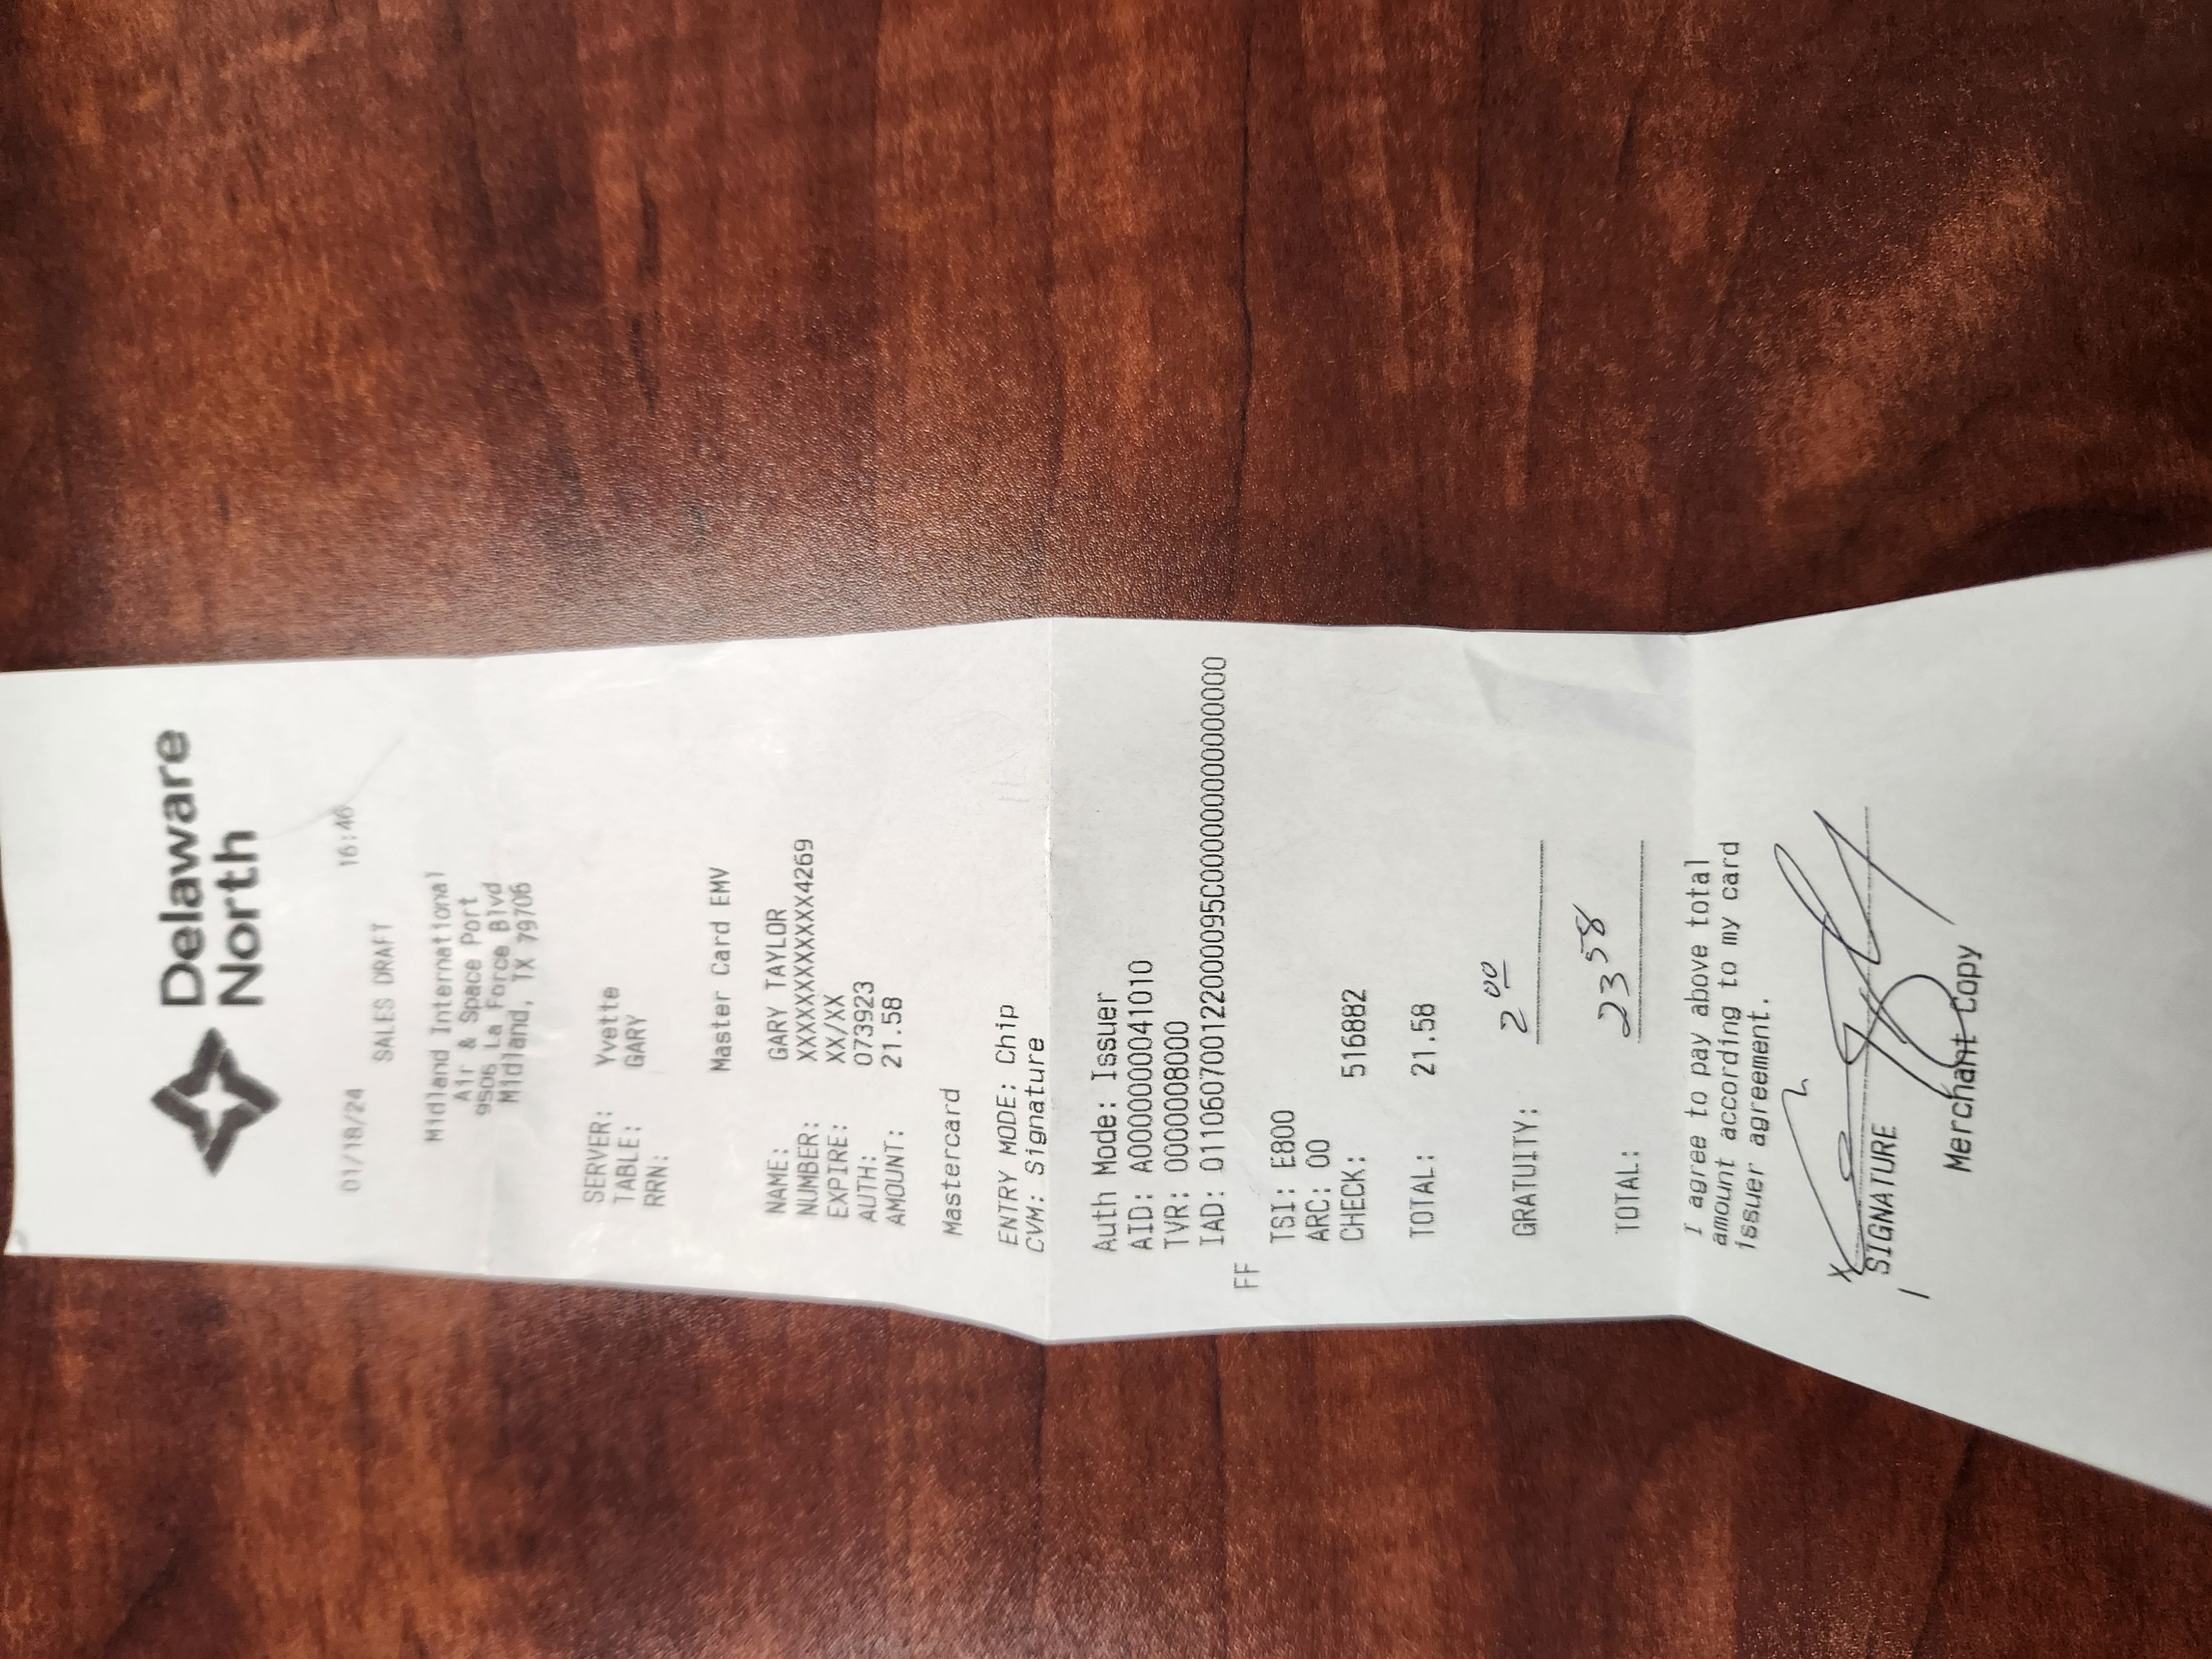

In [ ]:
result = get_image_informations("Receipts/Midland_Airport_23.58.jpg")
print(result)

In [ ]:

# file_size_bytes = get_file_size("Receipts/IMG_0102.jpg")
# file_size_mb = file_size_bytes / (1024 * 1024)
# print(f"Original file size: {file_size_mb:.2f} MB")


<ipython-input-53-914c8acb4dda>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_dimensions, Image.ANTIALIAS)


Original Image too large (2.99 MB), resized image saved as Receipts/resized_image.jpg, with size of 1.33 MB


In [ ]:
import pprint
pprint.pp(result)

{'transaction_date': ['01/12/2024', 'HIGH'],
 'total_amount': [23.58, 'HIGH'],
 'tax_amount': [2.0, 'HIGH'],
 'currency': ['$', 'HIGH'],
 'merchant': ['Delaware North', 'HIGH'],
 'merchant_location': ['Midland Terminal, 7000 George J. Bean Parkway, Tampa, '
                       'FL 33607',
                       'HIGH'],
 'expense_summary': ['meal at Delaware North on 01/12/2024', 'HIGH'],
 'expense_category': ['Meal-Dinner', 'HIGH']}
